## Analyzing Flight Interconnected Data 
### Students: 
- LE Thi Hoa - 12310380
- TRAN Hai Linh - 12310487

### The objective of this project
- The objective of this project is to use Spark’s APIs to analyze the flight interconnected data to find which are the most popular airports. To do so, you’ll need to implement the PageRank algorithm natively on Spark SQL.

### Libraries and Environment

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

### Initialize SparkSession 

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName('Graph Processing') \
    .getOrCreate()

23/11/26 18:05:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Load the dataset and display a few rows

In [64]:
# load dataset
data_path = "2018.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [65]:
# Display a few rows
df.show(2, truncate=False, vertical=True)

-RECORD 0-------------------------
 FL_DATE             | 2018-01-01 
 OP_CARRIER          | UA         
 OP_CARRIER_FL_NUM   | 2429       
 ORIGIN              | EWR        
 DEST                | DEN        
 CRS_DEP_TIME        | 1517       
 DEP_TIME            | 1512.0     
 DEP_DELAY           | -5.0       
 TAXI_OUT            | 15.0       
 WHEELS_OFF          | 1527.0     
 WHEELS_ON           | 1712.0     
 TAXI_IN             | 10.0       
 CRS_ARR_TIME        | 1745       
 ARR_TIME            | 1722.0     
 ARR_DELAY           | -23.0      
 CANCELLED           | 0.0        
 CANCELLATION_CODE   | null       
 DIVERTED            | 0.0        
 CRS_ELAPSED_TIME    | 268.0      
 ACTUAL_ELAPSED_TIME | 250.0      
 AIR_TIME            | 225.0      
 DISTANCE            | 1605.0     
 CARRIER_DELAY       | null       
 WEATHER_DELAY       | null       
 NAS_DELAY           | null       
 SECURITY_DELAY      | null       
 LATE_AIRCRAFT_DELAY | null       
 Unnamed: 27        

In [66]:
# print the schema of data
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: do

#### Based on the schema, here is the meaning of each column
- **FL_DATE**: Date of the flight.
- **OP_CARRIER**: Operating Carrier code, indicating the airline that performed the flight.
- **OP_CARRIER_FL_NUM:** Flight number assigned by the operating carrier.
- **ORIGIN:** Three-letter code for the origin airport.
- **DEST:** Three-letter code for the destination airport.
- **CRS_DEP_TIME**: Scheduled departure time.
- **DEP_TIME:** Actual departure time.
- **DEP_DELAY:** Difference in minutes between actual and scheduled departure times.
- **TAXI_OUT:** Time in minutes from departure from the origin gate to wheels off.
- **WHEELS_OFF**: Actual departure time when the aircraft wheels leave the ground.
- **WHEELS_ON:** Actual arrival time when the aircraft wheels touch the ground.
- **TAXI_IN:** Time in minutes from wheels-on to arrival at the destination gate.
- **CRS_ARR_TIME:** Scheduled arrival time.
- **ARR_TIME:** Actual arrival time.
- **ARR_DELAY:** Difference in minutes between actual and scheduled arrival times.
- **CANCELLED:** Indicates whether the flight was canceled (1) or not (0).
- **CANCELLATION_CODE:** Code specifying the reason for cancellation.
- **DIVERTED:** Indicates whether the flight was diverted to another airport (1) or not (0).
- **CRS_ELAPSED_TIME:** Scheduled elapsed time of the flight.
- **ACTUAL_ELAPSED_TIME:** Actual elapsed time of the flight.
- **AIR_TIME:** Time the aircraft spends airborne.
- **DISTANCE:** Distance between airports.
- **CARRIER_DELAY:** Delay attributed to the carrier.
- **WEATHER_DELAY:** Delay attributed to weather conditions.
- **NAS_DELAY:** Delay attributed to the National Airspace System.
- **SECURITY_DELAY:** Delay attributed to security-related issues.
- **LATE_AIRCRAFT_DELAY**: Delay attributed to issues with the aircraft.
- **Unnamed: 27**: An unnamed column (seems to have no specific meaning).

In [67]:
num_flight = df.count()
print(f"Size of dataset: {num_flight}")

Size of dataset: 7213446


### Preprocessing

#### Check missing value

In [68]:
# list columns
columns = df.columns

# check missing value each column - calculate percentage
for column in columns: 
    check_null = df.filter(df[column].isNull()).count()
    print(f"Number of null values in {column} column: {check_null} - {round((check_null/num_flight)*100, 2)}%")

Number of null values in FL_DATE column: 0 - 0.0%


Number of null values in OP_CARRIER column: 0 - 0.0%


Number of null values in OP_CARRIER_FL_NUM column: 0 - 0.0%


Number of null values in ORIGIN column: 0 - 0.0%


Number of null values in DEST column: 0 - 0.0%


Number of null values in CRS_DEP_TIME column: 0 - 0.0%


Number of null values in DEP_TIME column: 112317 - 1.56%


Number of null values in DEP_DELAY column: 117234 - 1.63%


Number of null values in TAXI_OUT column: 115830 - 1.61%


Number of null values in WHEELS_OFF column: 115829 - 1.61%


Number of null values in WHEELS_ON column: 119246 - 1.65%


Number of null values in TAXI_IN column: 119246 - 1.65%


Number of null values in CRS_ARR_TIME column: 0 - 0.0%


Number of null values in ARR_TIME column: 119245 - 1.65%


Number of null values in ARR_DELAY column: 137040 - 1.9%


Number of null values in CANCELLED column: 0 - 0.0%


Number of null values in CANCELLATION_CODE column: 7096862 - 98.38%


Number of null values in DIVERTED column: 0 - 0.0%


Number of null values in CRS_ELAPSED_TIME column: 10 - 0.0%


Number of null values in ACTUAL_ELAPSED_TIME column: 134442 - 1.86%


Number of null values in AIR_TIME column: 134442 - 1.86%


Number of null values in DISTANCE column: 0 - 0.0%


Number of null values in CARRIER_DELAY column: 5860736 - 81.25%


Number of null values in WEATHER_DELAY column: 5860736 - 81.25%


Number of null values in NAS_DELAY column: 5860736 - 81.25%


Number of null values in SECURITY_DELAY column: 5860736 - 81.25%


Number of null values in LATE_AIRCRAFT_DELAY column: 5860736 - 81.25%


Number of null values in Unnamed: 27 column: 7213446 - 100.0%


#### Check duplicate values 

In [69]:
# Check and count duplicate rows
duplicate_count = df.dropDuplicates().count()

# Display
print(f"Number of duplicate lines: {num_flight - duplicate_count}")

Number of duplicate lines: 0


#### Check for canceled and diverted flights CANCELLED - DIVERTED

- CANCELLED - Indicates whether the flight was canceled (1) or not (0).

In [70]:
cancelled = df.filter(df["CANCELLED"] == 1)
num_cancelled = cancelled.count()
print(f"Number of cancelled flights {num_cancelled} - {round((num_cancelled/num_flight)*100, 2)}%")

Number of cancelled flights 116584 - 1.62%


- DIVERTED: Indicates whether the flight was diverted to another airport (1) or not (0).

In [71]:
diverted = df.filter(df["DIVERTED"] == 1)
num_diverted = diverted.count()
print(f"Number of the diverted flights: {num_diverted} - {round((num_diverted/num_flight)*100, 2)}%")

Number of the diverted flights: 17859 - 0.25%


### Data Cleaning

- Remove the canceled flights

In [72]:
df_flight = df.filter(df["CANCELLED"] == 0)
print(f"Total number of flights after removing canceled flights: {df_flight.count()}")

Total number of flights after removing canceled flights: 7096862


### Data Exploring 

#### top 10 airports as the most popular origins

In [75]:
origin = df_flight.groupby("ORIGIN").count()

# Sort by count column in descending order
origin_sorted = origin.sort("count", ascending=False)

# display
print(f"Total airport is the departure airport: {origin_sorted.count()}")
origin_sorted.show(10)

Total airport is the departure airport: 358


+------+------+
|ORIGIN| count|
+------+------+
|   ATL|387502|
|   ORD|325817|
|   DFW|273933|
|   DEN|234394|
|   CLT|227278|
|   LAX|219588|
|   SFO|173439|
|   PHX|172658|
|   IAH|171994|
|   LGA|164122|
+------+------+
only showing top 10 rows



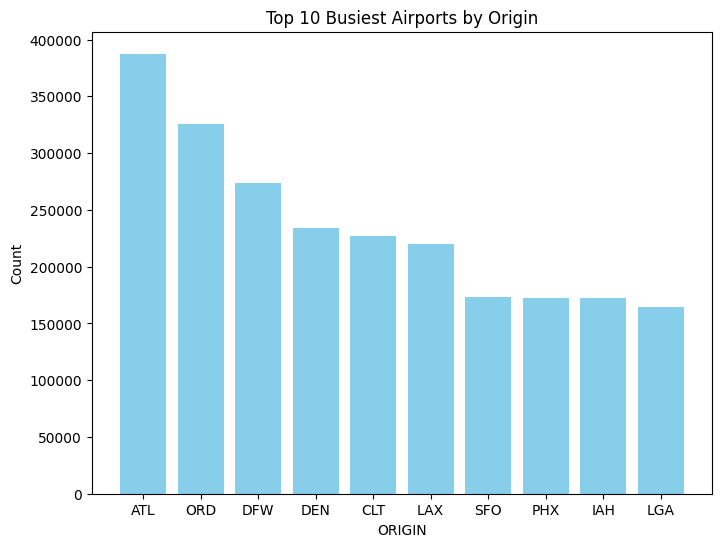

In [74]:
# top 10 airports as the most popular origins
top_10_origins = origin_sorted.toPandas().head(10)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(top_10_origins['ORIGIN'], top_10_origins['count'], color='skyblue')
plt.xlabel('ORIGIN')
plt.ylabel('Count')
plt.title('Top 10 Busiest Airports by Origin')
plt.show()

#### Top 10 airports as the most popular destinations

In [77]:
destination = df_flight.groupby("DEST").count()

# Sort by count column in descending order
destination_sorted = destination.sort("count", ascending=False)
print(f"Number of destinations: {destination_sorted.count()}")

# display
destination_sorted.show(10)

Number of destinations: 358


+----+------+
|DEST| count|
+----+------+
| ATL|387468|
| ORD|325322|
| DFW|273437|
| DEN|234110|
| CLT|226683|
| LAX|219514|
| SFO|173398|
| PHX|172286|
| IAH|171818|
| LGA|164186|
+----+------+
only showing top 10 rows



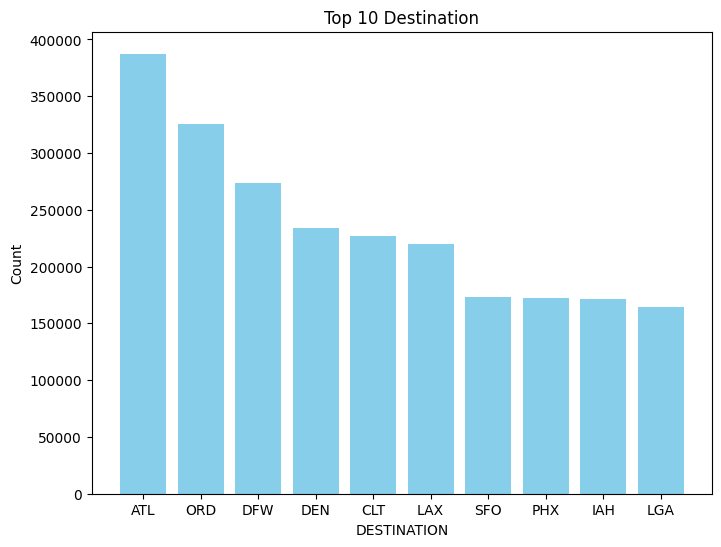

In [78]:
# Get the top 10 airports as the most popular destinations
top_10_destinations = destination_sorted.toPandas().head(10)

# Plot 
plt.figure(figsize=(8, 6))
plt.bar(top_10_destinations['DEST'], top_10_destinations['count'], color='skyblue')
plt.xlabel('DESTINATION')
plt.ylabel('Count')
plt.title('Top 10 Destination')
plt.show()

### Encode the dataset as a graph
- What are the vertices? What are the edges? How do you compute the weight?
    - **Vertices**: The vertices in this problem are the airports. Each airport is represented by a vertex in the graph.
    - **Edges:** The edges represent the routes between airports. If there is a direct flight from airport A to airport B, then there is an edge connecting A to B.
    - **Weight**: The weight of an edge (connection between two airports) can be computed as the total number of flights or the frequency of flights between those two airports. For example, if there were 100 flights from airport A to airport B in a given time period, the weight of the edge between A and B would be 100.

#### Vertices
- The vertices in this problem are the airports. Each airport is represented by a vertex in the graph.

- **Solution:**
    - Extracts unique airport codes from both the "ORIGIN" and "DEST" columns in the DataFrame (df_flight). 
    - The airports are collected into a set to remove duplicates
    - Then sorted to create a list of all unique vertices (airports) in the graph.

In [79]:
# Get a list of all vertices in the graph
all_airports = sorted(set(df_flight.select("ORIGIN").union(df_flight.select("DEST")).distinct().rdd.flatMap(lambda x: x).collect()))

# Calculate the number of vertices in the graph
num_vertices = len(all_airports)
print(f"Number of vertices in the graph: {num_vertices}")

# Create a DataFrame containing vertex information
vertices_df = spark.createDataFrame([(vertex,) for vertex in all_airports], ["VERTEX_SOURCE"])
vertices_df.show()

Number of vertices in the graph: 358
+-------------+
|VERTEX_SOURCE|
+-------------+
|          ABE|
|          ABI|
|          ABQ|
|          ABR|
|          ABY|
|          ACK|
|          ACT|
|          ACV|
|          ACY|
|          ADK|
|          ADQ|
|          AEX|
|          AGS|
|          AKN|
|          ALB|
|          ALO|
|          AMA|
|          ANC|
|          APN|
|          ART|
+-------------+
only showing top 20 rows



#### Edges - Weight
- **Edges:** The edges represent the routes between airports. If there is a direct flight from airport A to airport B, then there is an edge connecting A to B.
- **Weight**: The weight of an edge (connection between two airports) can be computed as the total number of flights or the frequency of flights between those two airports. For example, if there were 100 flights from airport A to airport B in a given time period, the weight of the edge between A and B would be 100.

**Solution:**

- Group by pair ORIGIN and DEST, and calculate the total number of flights
- Renames the count column to "weight"

In [80]:
# Groupby pair ORIGIN and DEST, and calculate the total number of flights
edges_df = df_flight.groupBy("ORIGIN", "DEST").count()
edges_df = edges_df.withColumnRenamed("count", "weight")

# Display a DataFrame with edges and flight numbers - weight
edges_df.show()

+------+----+------+
|ORIGIN|DEST|weight|
+------+----+------+
|   ORD| PDX|  2738|
|   FSD| ATL|   308|
|   ATL| GSP|  3756|
|   BQN| MCO|   556|
|   PBI| DCA|  1082|
|   PHL| MCO|  5124|
|   TPA| ACY|   362|
|   STS| PHX|   371|
|   SPI| ORD|   980|
|   LAS| LIT|   365|
|   MCI| MKE|   603|
|   MDW| MEM|   679|
|   SMF| BUR|  2801|
|   SNA| PHX|  4090|
|   MCI| IAH|  1721|
|   DSM| EWR|   265|
|   DSM| MCO|   124|
|   SJC| LIH|   287|
|   PIE| AVP|     1|
|   PBG| PGD|    26|
+------+----+------+
only showing top 20 rows



### Implement the PageRank algorithm 
- Implement the PageRank algorithm natively

**Solution**

- It starts by calculating the total number of edges coming out of each vertex (outDegree)
- Constructing an adjacency matrix
- Normalizing it to a probability matrix
- Then iteratively calculating PageRank values until convergence

**The damping factor** is a parameter used in the PageRank algorithm to model the probability that a user will continue clicking on links rather than jumping to a new page. It introduces a level of randomness to the model, simulating the behavior of a web surfer who, with a certain probability, might decide to navigate to a random page instead of following links.

- In the context of the PageRank algorithm, the damping factor is typically denoted by the symbol d. The standard value for d is often set to 0.85, but it can vary depending on the specific application. The remaining probability, 1−d, is distributed evenly among all the nodes in the graph, reflecting the surfer's chance of jumping to any page at random.

- Here's how the damping factor is incorporated into the PageRank formula:

$$PageRank(A) = \frac{1-d}{N} + d \times \left(\frac{PageRank(B)}{L(B)} + \frac{PageRank(C)}{L(C)} + \ldots\right)$$

- In there: 
    - PageRank(A) is the PageRank of page A.
    - N is the total number of nodes in the graph.
    - d is the damping factor.
    - PageRank(B),PageRank(C),… are the PageRanks of pages that link to page A.
    - L(B),L(C),… are the number of outbound links on pages B, C, etc.


#### i. Calculate the total number of edges coming out of each vertex (outDegree)
- The outDegree is calculated for each airport, representing the total number of flights leaving each airport.

-  This helps quantify the level of "power" of each vertex in transmitting its rank score to other vertices.

**Solution**
- Calculates the outDegree by grouping the edges_df DataFrame by "ORIGIN" 
- Aggregating the sum of weights (flights) for each origin airport.

In [81]:
# Calculate the total number of edges coming out of each vertex (outDegree)
out_degree = (
    edges_df
    .groupBy("ORIGIN")
    .agg(F.sum("weight").alias("out_degree"))
).orderBy("ORIGIN")


# Display outDegree
out_degree.show()

+------+----------+
|ORIGIN|out_degree|
+------+----------+
|   ABE|      4081|
|   ABI|      1981|
|   ABQ|     23809|
|   ABR|       737|
|   ABY|      1007|
|   ACK|       937|
|   ACT|      1534|
|   ACV|      1429|
|   ACY|      3248|
|   ADK|       101|
|   ADQ|       618|
|   AEX|      3355|
|   AGS|      4455|
|   AKN|        63|
|   ALB|     12097|
|   ALO|       655|
|   AMA|      5262|
|   ANC|     18282|
|   APN|       608|
|   ART|        24|
+------+----------+
only showing top 20 rows



#### ii. Build adjacency matrix from DataFrame

- Adjacency matrix - representing the connections (flights) between each pair of airport
**Solution:** 
- It does a cross join on the vertices_df to create all possible combinations of source and destination airports. 
- Then joins with the edges_df to get the weights (flight counts) for each airport pair
- The result is a DataFrame (adjacency_matrix) with airports as rows, airports as columns, and flight counts as values.

In [82]:
# Build adjacency matrix from DataFrame
adjacency_matrix = (
    vertices_df
    .crossJoin(vertices_df.withColumnRenamed("VERTEX_SOURCE", "VERTEX_DEST"))
    .join(edges_df, (F.col("VERTEX_SOURCE") == F.col("ORIGIN")) & (F.col("VERTEX_DEST") == F.col("DEST")), "left_outer")
    .groupBy("VERTEX_SOURCE")
    .pivot("VERTEX_DEST", all_airports)
    .agg(F.coalesce(F.sum("weight"), F.lit(0)))
    .na.fill(0)
).orderBy("VERTEX_SOURCE")

# display adjacency matrix
#adjacency_matrix.show()


#### iii. Normalizing it to a probability matrix
- Convert adjacency matrix from DataFrame to NumPy array
- The adjacency matrix is normalized to create a probability matrix. 
- Each element in the matrix is divided by the corresponding outDegree to convert the counts into probabilities.

In [83]:
# Convert adjacency matrix from DataFrame to NumPy array
adjacency_matrix_np = np.array(adjacency_matrix.select(all_airports).collect())

# Normalize the matrix to get the probability matrix
out_degree_np = np.array(out_degree.select("ORIGIN", "out_degree").collect())
out_degree_dict = dict(zip(out_degree_np[:, 0], out_degree_np[:, 1]))
adjacency_matrix_np_normalized = adjacency_matrix_np / (out_degree_np[:, 1][:, np.newaxis]).astype("float")

print(out_degree_dict)

{'ABE': '4081', 'ABI': '1981', 'ABQ': '23809', 'ABR': '737', 'ABY': '1007', 'ACK': '937', 'ACT': '1534', 'ACV': '1429', 'ACY': '3248', 'ADK': '101', 'ADQ': '618', 'AEX': '3355', 'AGS': '4455', 'AKN': '63', 'ALB': '12097', 'ALO': '655', 'AMA': '5262', 'ANC': '18282', 'APN': '608', 'ART': '24', 'ASE': '6407', 'ATL': '387502', 'ATW': '4131', 'AUS': '62650', 'AVL': '7512', 'AVP': '3253', 'AZA': '5215', 'AZO': '2724', 'BDL': '27664', 'BET': '810', 'BFF': '570', 'BFL': '2301', 'BGM': '909', 'BGR': '3913', 'BHM': '17973', 'BIL': '4129', 'BIS': '3611', 'BJI': '737', 'BKG': '69', 'BLI': '2208', 'BLV': '1011', 'BMI': '3082', 'BNA': '73182', 'BOI': '19108', 'BOS': '144347', 'BPT': '818', 'BQK': '1028', 'BQN': '1942', 'BRD': '626', 'BRO': '2526', 'BRW': '714', 'BTM': '676', 'BTR': '7451', 'BTV': '9343', 'BUF': '25577', 'BUR': '26128', 'BWI': '104419', 'BZN': '5812', 'CAE': '6653', 'CAK': '7302', 'CDC': '621', 'CDV': '716', 'CGI': '603', 'CHA': '8370', 'CHO': '5372', 'CHS': '23042', 'CID': '9050', 

#### iv. iteratively calculating PageRank values until convergence
- The initial PageRank values for all vertices are set. All vertices are given equal initial importance.
- Iteratively calculates the PageRank values for each airport. 
- It uses the PageRank formula, considering the normalized adjacency matrix and damping factor. 
- The loop continues until convergence (change in PageRank values is below a tolerance level), or until the specified number of iterations is reached.

In [84]:
#Initialize the initial pagerank value
ranks_np = np.ones(num_vertices) / num_vertices

# damping factor
damping_factor_np = 0.85

# Number of iterations
num_iterations_np = 100

# Convergence threshold
tolerance = 1e-6

# Loop to calculate PageRank
for i in range(num_iterations_np):
    # Calculate the total pagerank * weight for each target vertex
    contributions_np = np.dot(adjacency_matrix_np_normalized.T, ranks_np)
    
    # Calculate new pagerank based on PageRank formula
    new_ranks_np = (1 - damping_factor_np) / num_vertices + damping_factor_np * contributions_np

    # Check for convergence
    if np.linalg.norm(new_ranks_np - ranks_np, 2) < tolerance:
        print(f"Converged after {i+1} iterations.")
        break

    ranks_np = new_ranks_np

# Display results
for vertex, rank in zip(all_airports, ranks_np):
    print(f"{vertex} - PageRank: {round(rank, 5)}")

Converged after 20 iterations.
ABE - PageRank: 0.00103
ABI - PageRank: 0.00067
ABQ - PageRank: 0.00292
ABR - PageRank: 0.00051
ABY - PageRank: 0.00053
ACK - PageRank: 0.00051
ACT - PageRank: 0.00061
ACV - PageRank: 0.00056
ACY - PageRank: 0.00076
ADK - PageRank: 0.00045
ADQ - PageRank: 0.00063
AEX - PageRank: 0.00079
AGS - PageRank: 0.0009
AKN - PageRank: 0.00044
ALB - PageRank: 0.00166
ALO - PageRank: 0.00049
AMA - PageRank: 0.001
ANC - PageRank: 0.0072
APN - PageRank: 0.00061
ART - PageRank: 0.00042
ASE - PageRank: 0.00117
ATL - PageRank: 0.04811
ATW - PageRank: 0.00097
AUS - PageRank: 0.00699
AVL - PageRank: 0.00136
AVP - PageRank: 0.00077
AZA - PageRank: 0.00243
AZO - PageRank: 0.00074
BDL - PageRank: 0.00327
BET - PageRank: 0.00069
BFF - PageRank: 0.00049
BFL - PageRank: 0.00067
BGM - PageRank: 0.00052
BGR - PageRank: 0.00087
BHM - PageRank: 0.0023
BIL - PageRank: 0.00096
BIS - PageRank: 0.00092
BJI - PageRank: 0.00051
BKG - PageRank: 0.00043
BLI - PageRank: 0.0007
BLV - PageRank:

### Visualization
- Select a subset of airports with high PageRank to display.
- Use networkx library to create graphs and matplotlib to draw graphs.

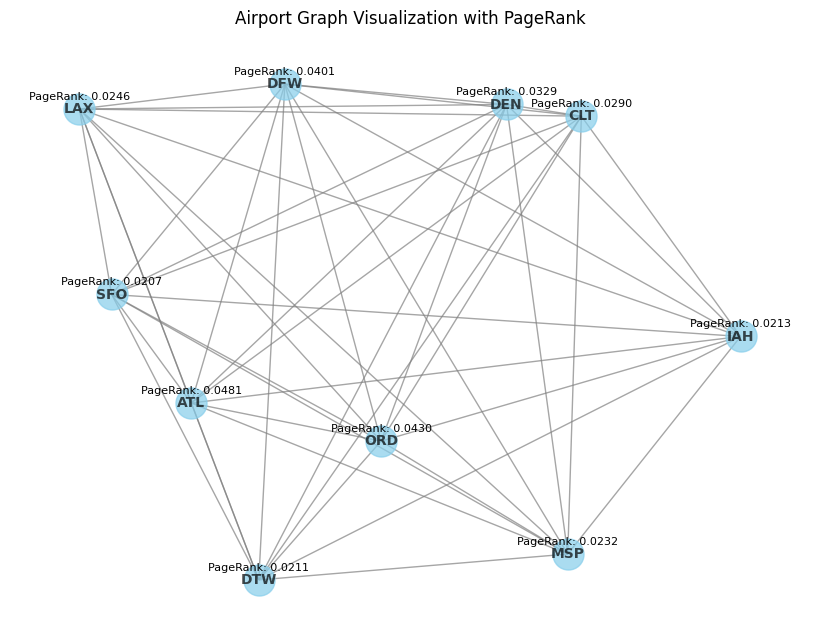

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


# Convert Spark DataFrame to Pandas DataFrame
edges_pd = edges_df.toPandas()

# Choose a subset of airports to visualize (for example, the top 10 by PageRank)
top_airports = pd.DataFrame({'Airport': all_airports, 'PageRank': ranks_np}).nlargest(10, 'PageRank')['Airport']

# Create a subgraph with only the selected airports and their connections
subgraph_df = edges_pd[edges_pd['ORIGIN'].isin(top_airports) & edges_pd['DEST'].isin(top_airports)]
subgraph = nx.from_pandas_edgelist(subgraph_df, 'ORIGIN', 'DEST', ['weight'])

# Create a layout for the graph
layout = nx.spring_layout(subgraph)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(subgraph, pos=layout, with_labels=True, node_size=500, 
        node_color='skyblue', font_size=10, font_color='black', font_weight='bold', 
        edge_color='gray', linewidths=1, alpha=0.7)

# Annotate nodes with their PageRank values
for airport in top_airports:
    plt.annotate(f'PageRank: {ranks_np[all_airports.index(airport)]:.4f}', 
                 xy=layout[airport], xytext=(layout[airport][0], layout[airport][1] + 0.03), 
                 ha='center', fontsize=8, color='black')

plt.title('Airport Graph Visualization with PageRank')
plt.show()
